In [7]:
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;
import os;

dat = pd.DataFrame(columns=["Device","Mesh","Splitting","Shading","Coloring","Resolution","Framerates"]);
print(dat);

Empty DataFrame
Columns: [Device, Mesh, Splitting, Shading, Coloring, Resolution, Framerates]
Index: []


In [8]:
# We assume that we have a results_total directory that contains one directory per device that run the test, which in turn contains a directory for every model with each type of coloring which contains the results
# Example ./results_total/my_pc/drawing_wedge_tex.ply/uber_flat_960x540.csv
pth = "./results_total/"
devices = os.listdir("./results_total/");
for device in devices:
    for mesh_unparsed in os.listdir(pth + device):
        mesh = mesh_unparsed
        coloring = ""
        if(mesh.find("_col") != -1):
            mesh = mesh.replace("_col", "")
            coloring += "color"
        if(mesh.find("_tex") != -1):
            mesh = mesh.replace("_tex", "")
            coloring += "texture"
        if(mesh.find("_vert") != -1):
            mesh = mesh.replace("_vert", "")
            coloring = "vertex " + coloring
        if(mesh.find("_face") != -1):
            mesh = mesh.replace("_face", "")
            coloring = "face " + coloring
        if(mesh.find("_wedge") != -1):
            mesh = mesh.replace("_wedge", "")
            coloring = "wedge " + coloring
        for csv_file in os.listdir(pth + device + "/" + mesh_unparsed):
            splitting = ""
            shading = ""
            resolution = ""
            framerates = []
            for splits in ["uber", "split", "uber_static_if"]:
                if csv_file.find(splits) != -1:
                    splitting = splits
            for shad in ["flat", "smooth"]:
                if csv_file.find(shad) != -1:
                    shading = shad
            for res in ["960x540", "2560x1440"]:
                if csv_file.find(res) != -1:
                    resolution = res
            with open(pth + device + "/" + mesh_unparsed + "/" + csv_file) as f:
                file_string = f.read()
                framerates = [float(x) for x in file_string.split("\n") if x!=""]
            dat = pd.concat([dat, pd.DataFrame([[device,mesh,splitting,shading,coloring,resolution,framerates]], columns=dat.columns)], ignore_index=True)





        

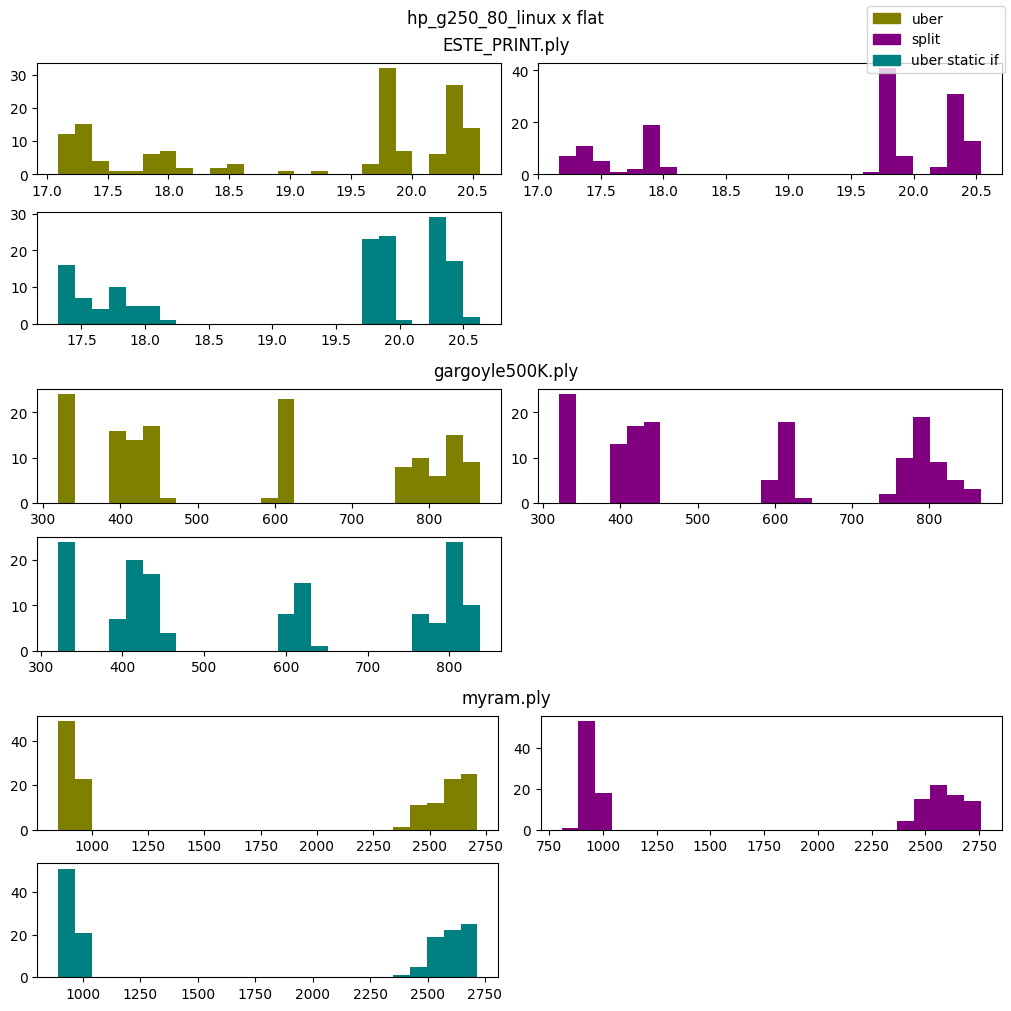

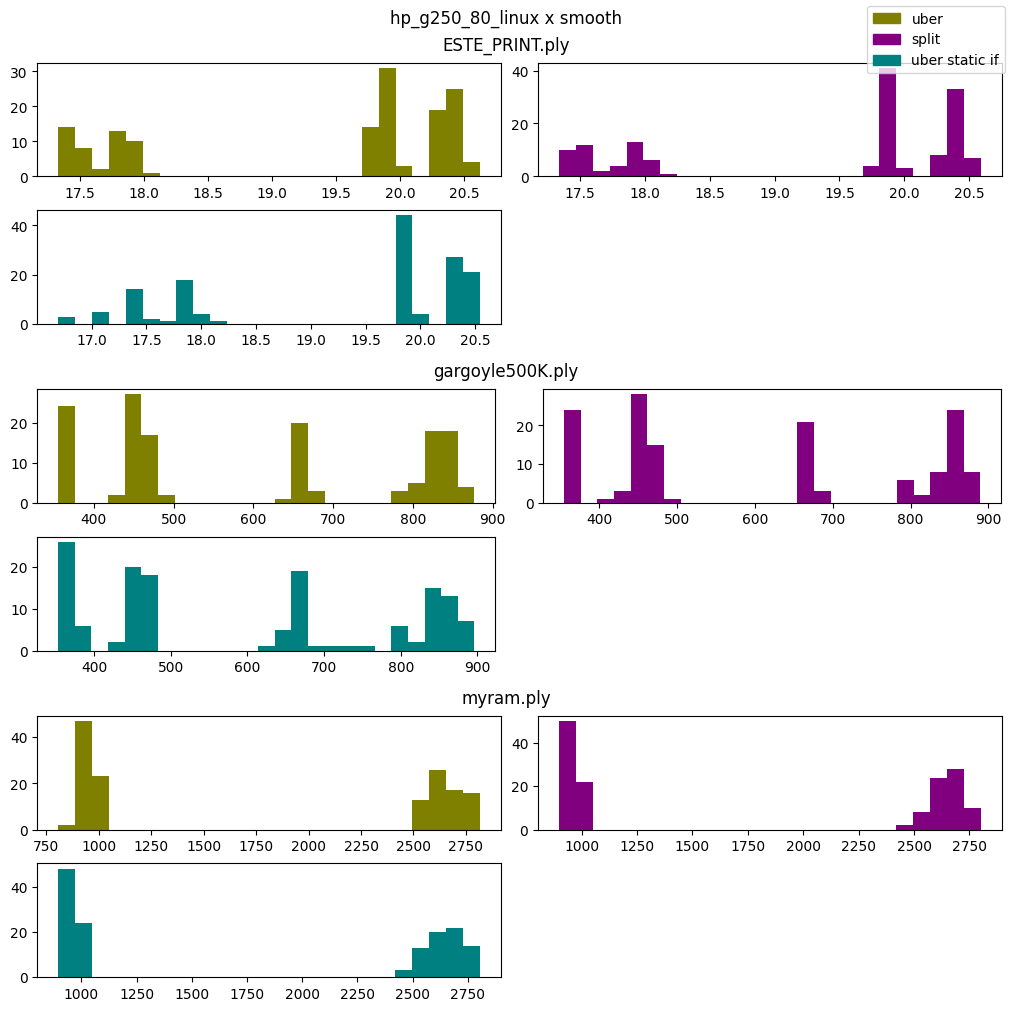

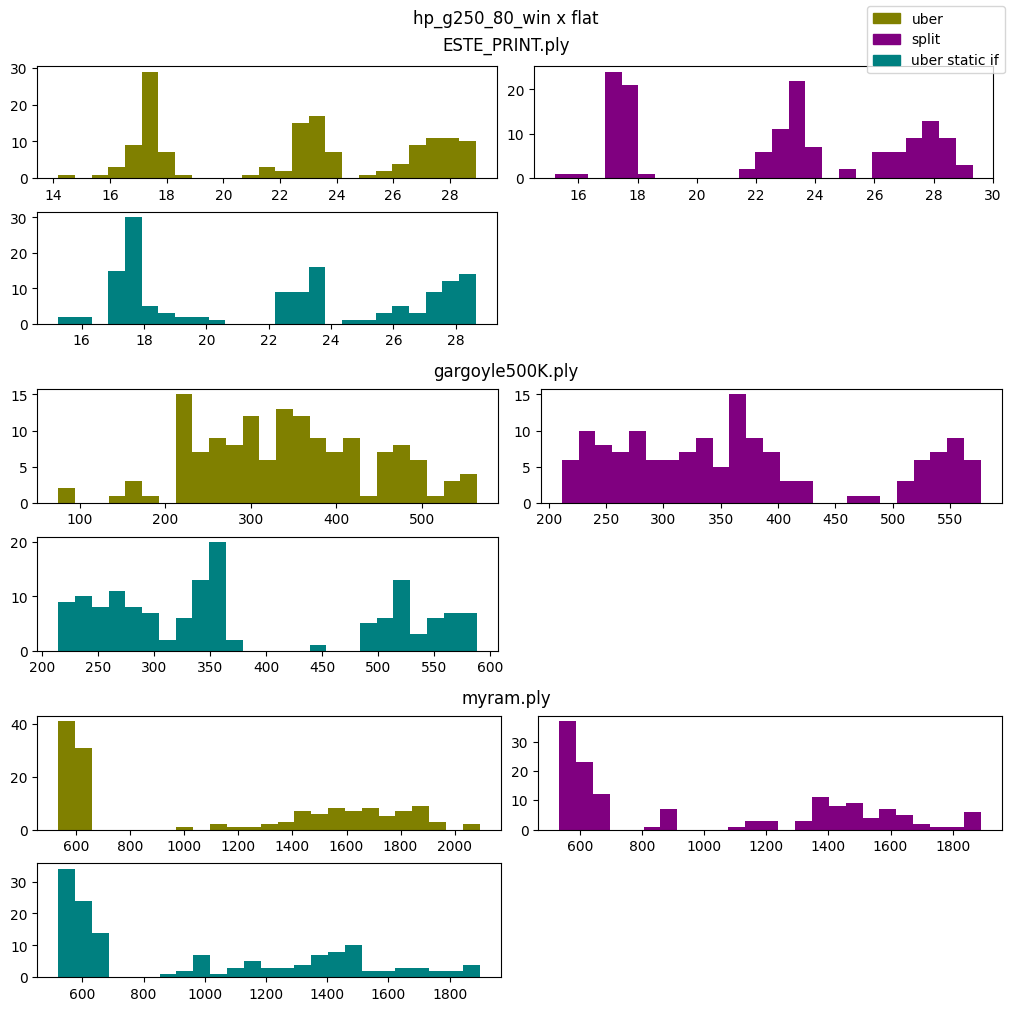

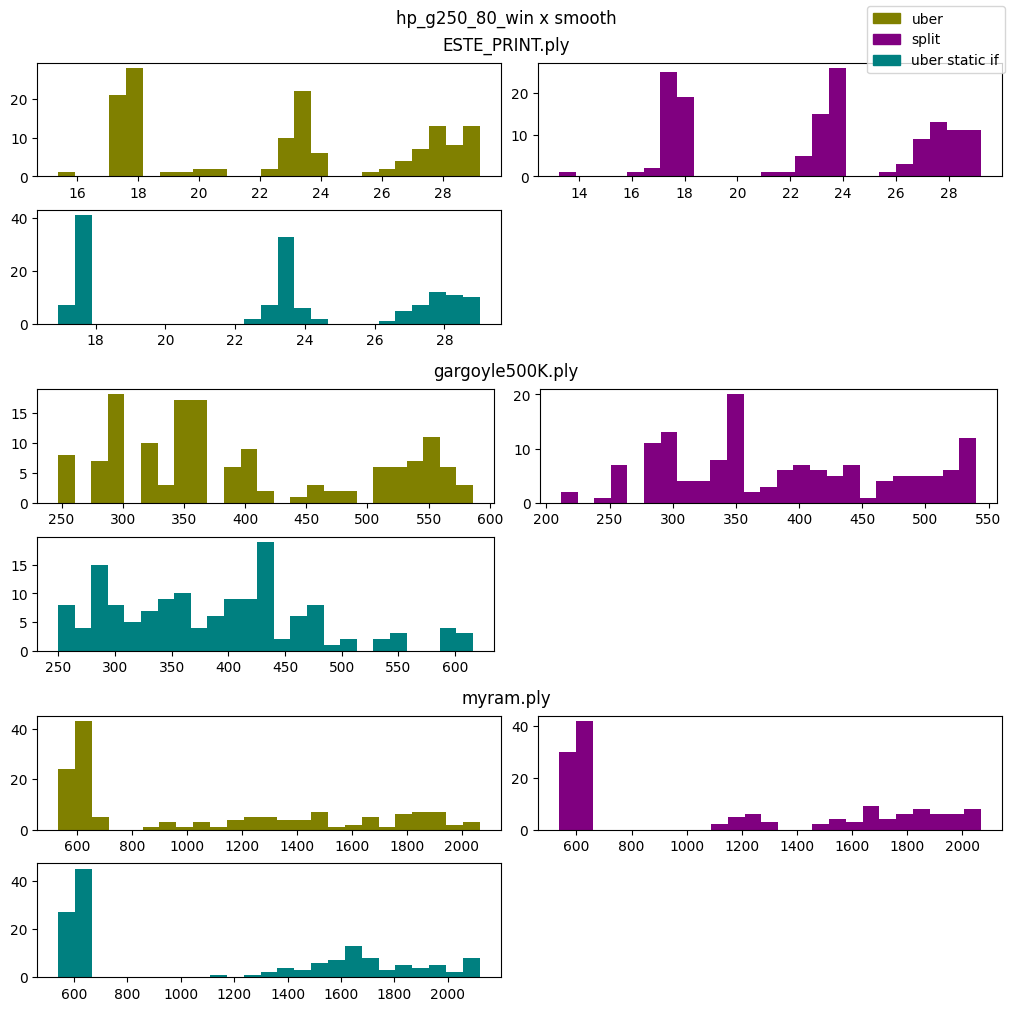

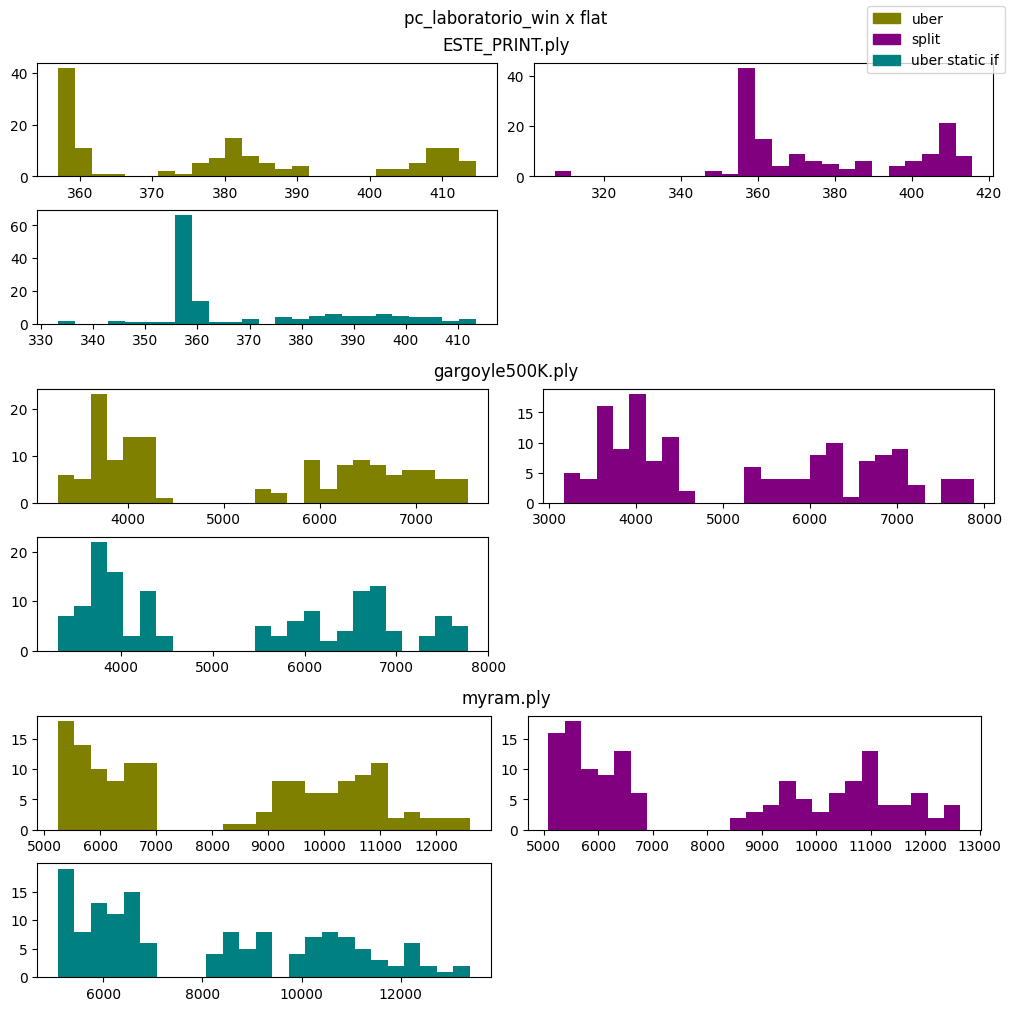

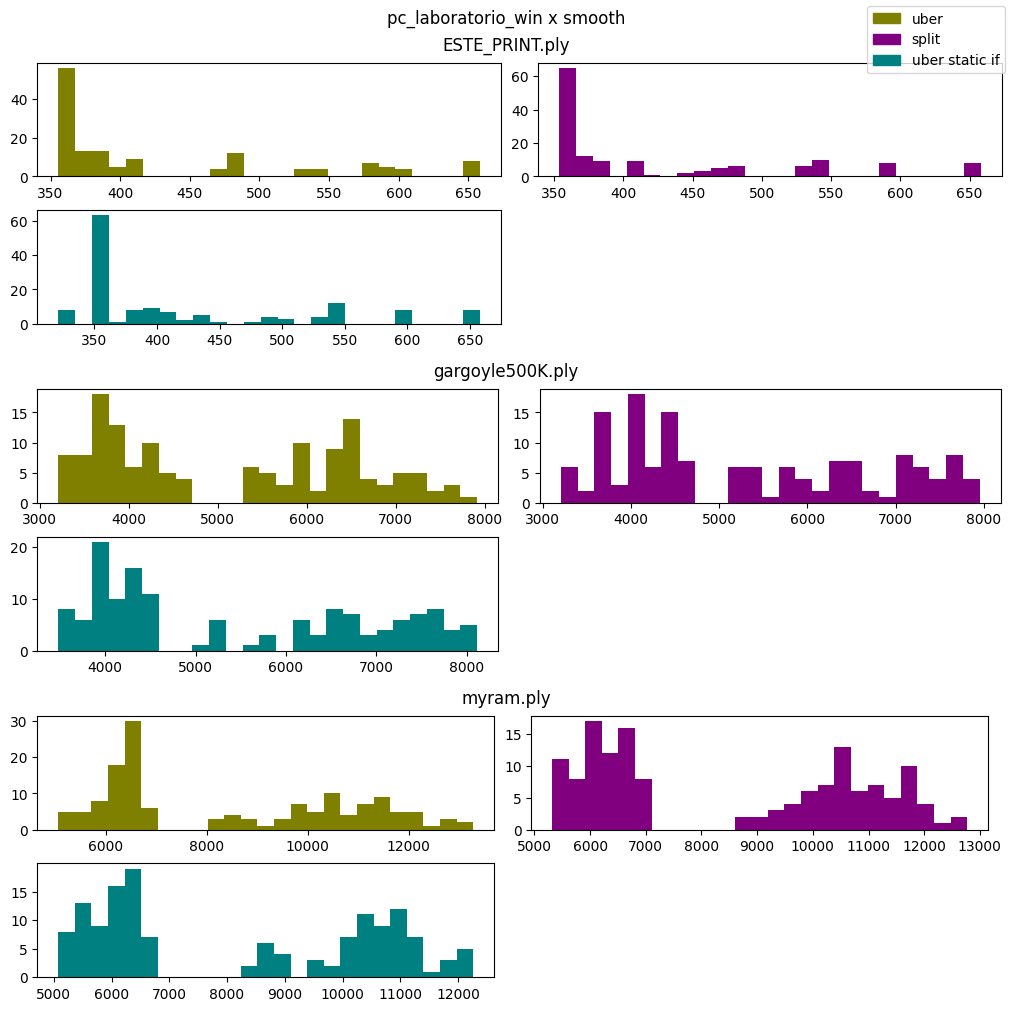

In [9]:
def plot_hists(dataset, device, meshes: list[str], shading = None):
    colors = ["#808000", '#800080', "#008080"]
    handles = [plt.Rectangle((0,0),1,1,color=c) for c in colors]
    filtered = dataset[dataset.Device == device]
    if shading is not None:
        filtered = filtered[filtered.Shading == shading]
    fig = plt.figure(figsize = (10,10), layout="constrained")
    fig.suptitle(device + (" x " + shading) if shading is not None else "")
    fig.legend(handles, ["uber", "split", "uber static if"])
    subfigs: list[plt.SubFigure] = fig.subfigures(3, 1)
    axs = []
    leg_loc = None
    for (i, subfig) in enumerate(subfigs):
        subfig.suptitle(meshes[i])
        sub_sub: list[plt.Axes] = subfig.subplots(2, 2).flatten()
        sub_sub[3].axis("off")
        bb = sub_sub[3].bbox
        centr = (bb.xmin+bb.width/2, bb.ymin+bb.height/2)
        leg_loc = leg_loc if leg_loc != None else centr
        axs.extend(sub_sub[0:3])
    index = 0
    for mesh in meshes:
        temp = filtered[filtered.Mesh == mesh]
        for shad in ["uber", "split", "uber_static_if"]:
            arr = [x for y in (temp[temp.Splitting == shad])["Framerates"] for x in y]
            ax: plt.Axes = axs[index]
            ax.hist(arr, 25, color=colors[index % 3])
            index += 1
    plt.show()

for device in devices:
    for shad in ["flat", "smooth"]:
        plot_hists(dat, device, dat["Mesh"].unique(), shad)

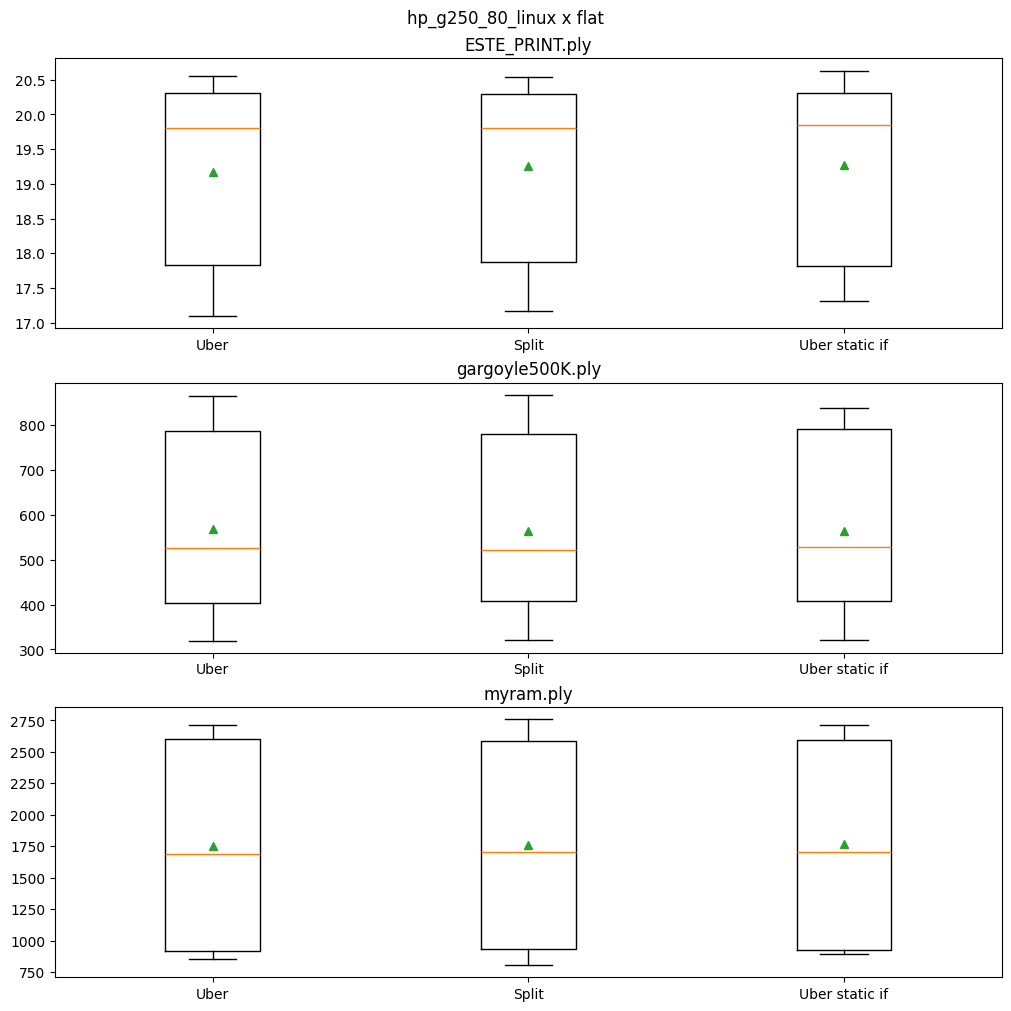

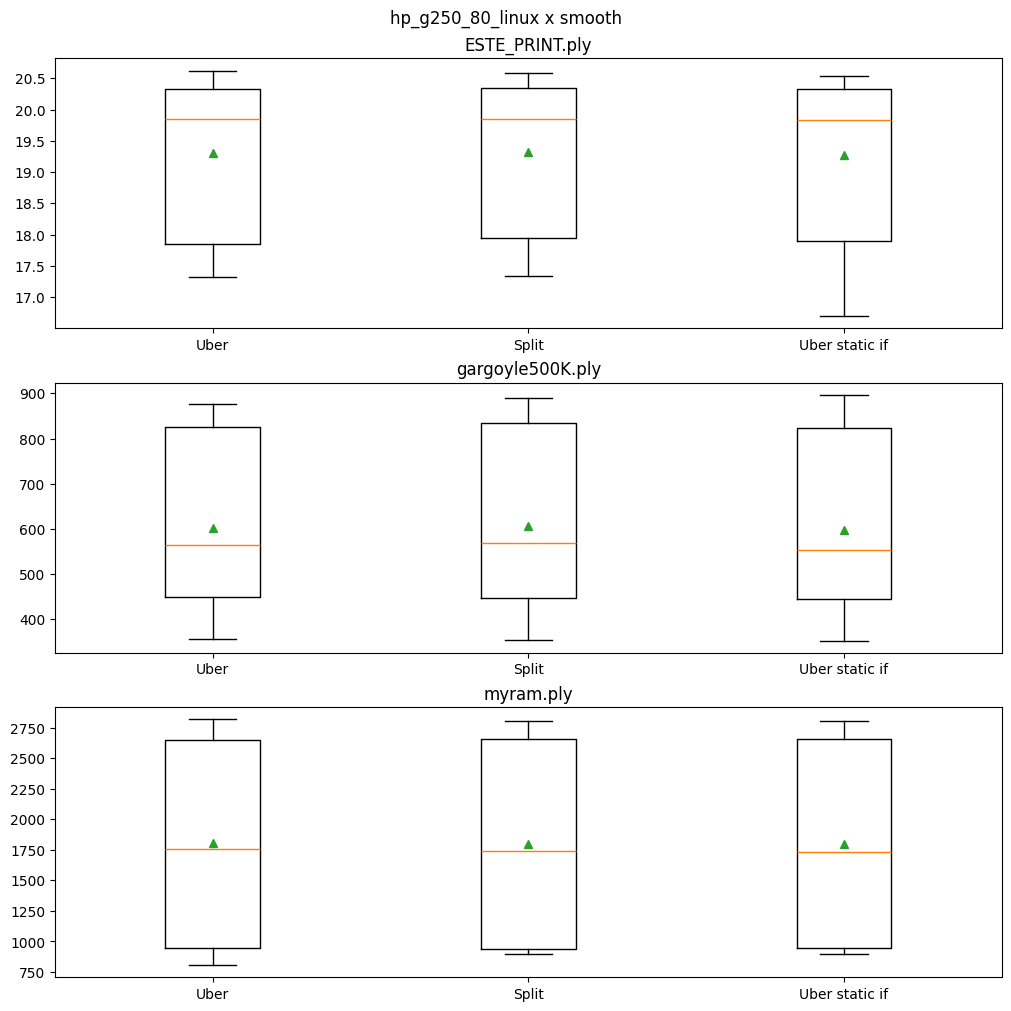

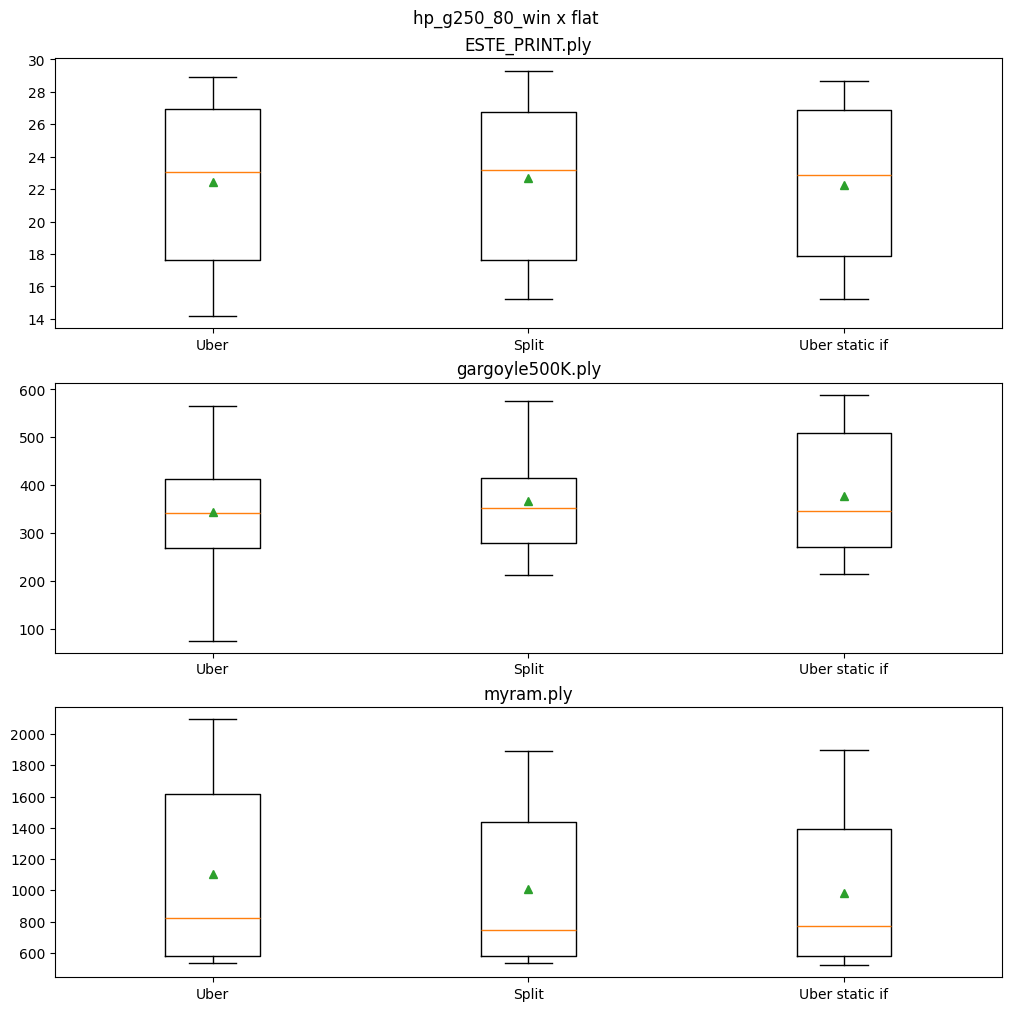

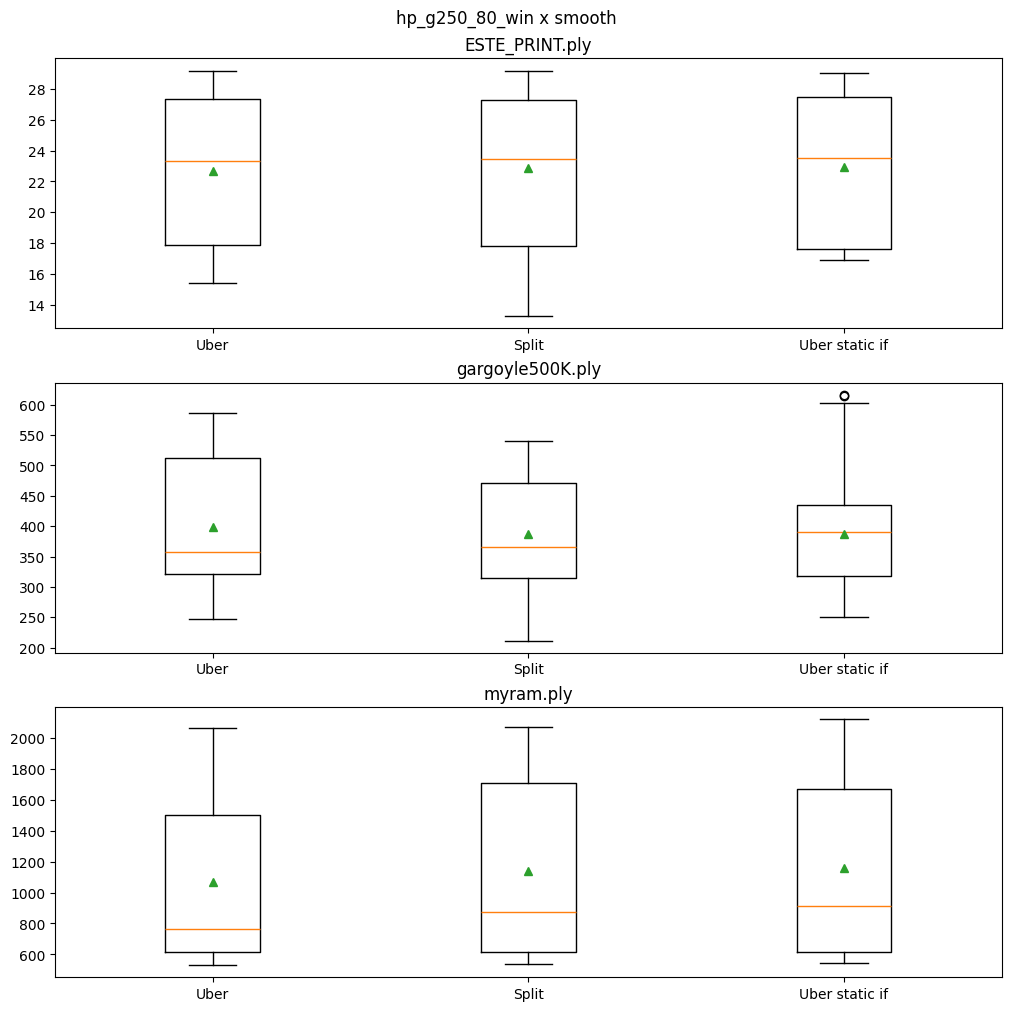

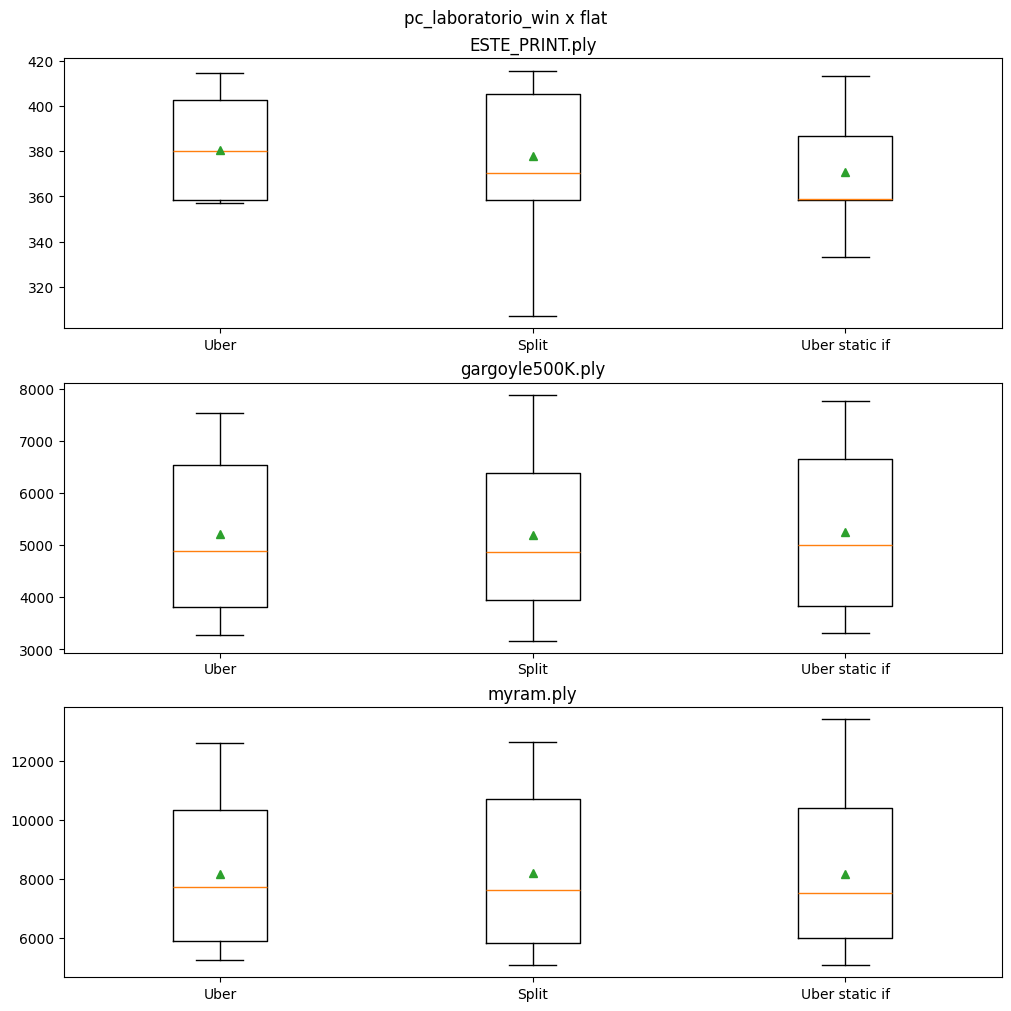

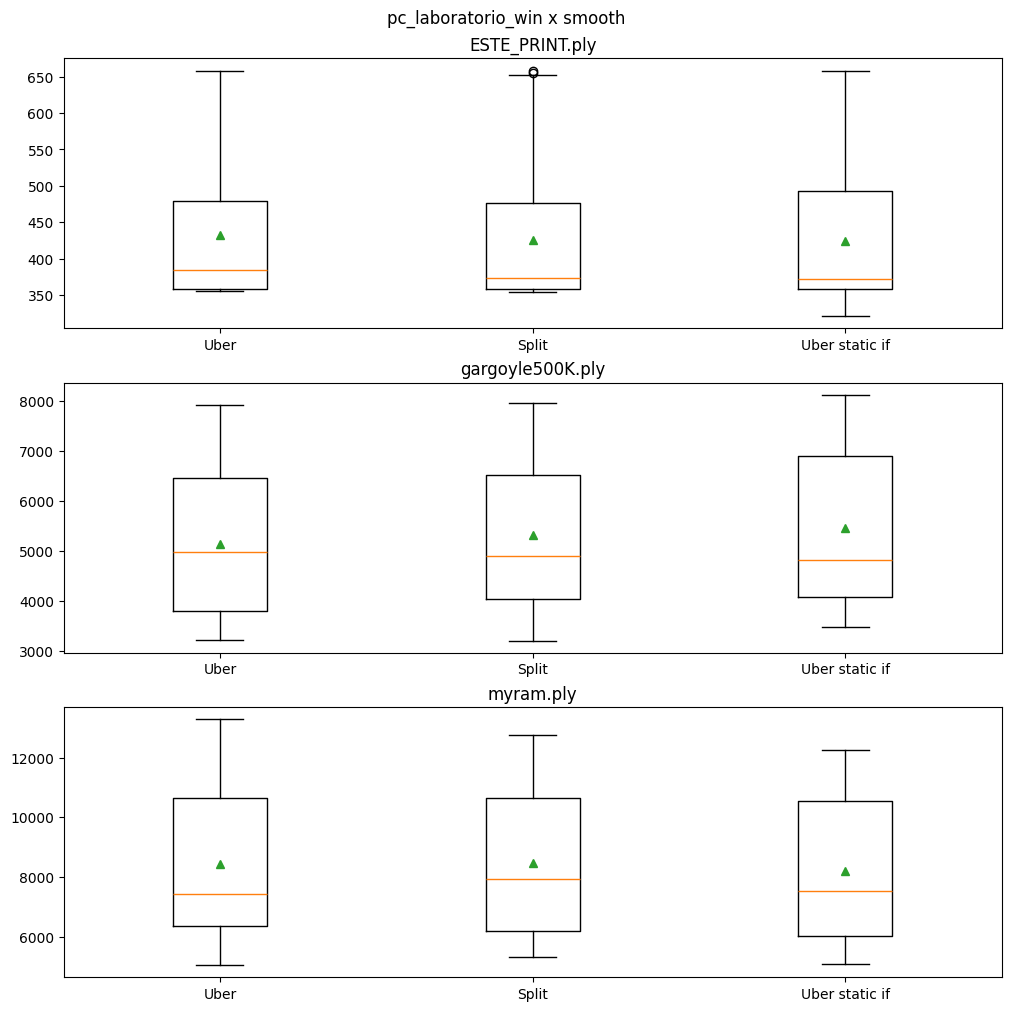

In [11]:
def plot_boxes(dataset, device, meshes, shading = None):
    filtered = dataset[dataset.Device == device]
    if shading is not None:
        filtered = filtered[filtered.Shading == shading]
    fig = plt.figure(figsize=(10,10), layout="constrained")
    fig.suptitle(device + (" x " + shading) if shading is not None else "")
    axs: list[plt.Axes] = fig.subplots(3, 1).flatten()
    for (i, mesh) in enumerate(meshes):
        temp = filtered[filtered.Mesh == mesh]
        arrs = []
        for split in ["uber", "split", "uber_static_if"]:
            arrs.append([x for y in temp[temp.Splitting == split]["Framerates"] for x in y])
        axs[i].boxplot(arrs, showmeans=True)
        axs[i].set_title(mesh)
        axs[i].set_xticklabels(["Uber","Split","Uber static if"])
    plt.show()

for device in devices:
    for shad in ["flat", "smooth"]:
        plot_boxes(dat, device, dat["Mesh"].unique(), shad)